# Objectives
- Understand the fundamentals of text clustering.
- Learn how to implement text clustering using Python.
- Explore creative applications of text clustering in various domains.
  
## What is Text Clustering?

Text clustering is an unsupervised machine learning technique that groups texts based on their semantic content, meaning, and relationships. This approach allows us to categorize large volumes of unstructured text efficiently, streamlining data organization and facilitating quick exploratory analysis.

## Why Text Clustering?

While classification methods have been prevalent in recent years, the significance of unsupervised techniques like text clustering is immense and often underappreciated. Here are some use cases of Text Clustering

1. **Initial Exploration Before Classification:** Before delving into complex classification tasks, text clustering offers an intuitive grasp of the data. It helps in understanding not only the task at hand but also the intricacies and complexities inherent in the data.

2. **Innovative Applications**: The unsupervised nature of text clustering opens up a plethora of creative possibilities. It's not just about grouping and classifying documents; it can be used for identifying inaccurate labels, conducting topic modeling, accelerating labeling processes, and much more.

3. **Discovering Patterns with Business Implications:** The insights gained from text clustering extend far beyond academic interest. They have practical applications in numerous business contexts. This includes
   - **Market Research**: By analyzing customer feedback and reviews, text clustering can reveal common themes, helping businesses understand consumer needs and preferences.
   - **Academic Research**: Scholars can use text clustering to categorize research papers, facilitating literature reviews and identifying research gaps.
   - **Healthcare Analysis**: In healthcare, clustering patient records and medical literature can help identify common symptoms or treatment approaches for certain conditions.
   - **Legal Document Organization**: For legal professionals, text clustering aids in organizing case files, legal precedents, and legislation, making it easier to find relevant information.
   - **Issue Identification**: It can pinpoint recurring issues in customer support communications.
   - **Content Strategy**: It aids in identifying new topics for SEO-driven content creation.
   - **Trend Analysis**: It's useful in spotting emerging topics on social media.
   - **Content Management**: It assists in detecting duplicate or similar content.

# Data: ArXiv Articles

In this notebook we will focus on clustering a selection of ArXiv articles in the realms of machine learning and natural language processing. The dataset comprises approximately XXX articles, spanning from XXX to XXX, providing a rich ground for our text clustering exploration.

In [1]:
# check if we are using google colab
from pathlib import Path
import textwrap
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount("/content/drive")
    !pip install datasets transformers bertopic umap hdbscan  openai -U -qq

    base_folder = Path("/content/drive/MyDrive/data")
else:
    base_folder = Path("/home/harpreet/Insync/google_drive_shaannoor/data")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# # Set the path to the .env file
# from dotenv import load_dotenv
# env_path = base_folder / '.env'  # Adjust the path accordingly

# # Load the .env file
# load_dotenv(dotenv_path=env_path)

# openai.api_key = os.getenv("OPENAI_API_KEY")

# if openai.api_key is None:
#     print("API key is not set.")
# else:
#     print("API key is set.")

In [3]:
def print_wrap(text, width=80):
    """
    Prints the given text, wrapping lines to a maximum of the specified width (default is 80 characters).

    Args:
    text (str): The text to be printed.
    width (int): The maximum width of a line, in characters.
    """
    wrapper = textwrap.TextWrapper(width=width)
    wrapped_text = wrapper.fill(text)
    print(wrapped_text)

In [4]:
data_folder = base_folder/'datasets/arxiv'
model_folder = base_folder/'models/nlp_fall_2023/clustering/arxiv'
model_folder.mkdir(exist_ok=True, parents=True)
data_folder.mkdir(exist_ok=True, parents=True)

## Import Data

In [5]:
import torch

In [6]:
torch.cuda.is_available()

True

In [7]:
from datasets import load_dataset
dataset = load_dataset("maartengr/arxiv_nlp")["train"]

In [8]:
dataset

Dataset({
    features: ['Titles', 'Abstracts', 'Years', 'Categories'],
    num_rows: 33189
})

In [9]:
dataset.features

{'Titles': Value(dtype='string', id=None),
 'Abstracts': Value(dtype='string', id=None),
 'Years': Value(dtype='int64', id=None),
 'Categories': Value(dtype='string', id=None)}

## Extract Meta data

In [10]:
abstracts = dataset["Abstracts"]
years = dataset["Years"]
titles = dataset["Titles"]

# Text Clustering Steps
Text clustering has three main steps

1. Embed documents

2. Reduce dimensionality

3. Cluster embeddings

## Embed Documents

### What is Document Embedding?

Document embedding is the process of converting text data into numerical vectors, known as embeddings. These vectors represent the semantic content of the documents in a high-dimensional space. Each dimension captures some aspect of the document's content, making these vectors extremely useful for various NLP tasks.

### Why are Embeddings Important?

Embeddings are crucial because they transform unstructured text into a structured, numerical form that machine learning algorithms can understand and process. This transformation allows for the analysis of relationships and patterns within the text at a semantic level.

### Why Sentence Transformers are a Good Choice:

1. **Contextual Representation**: Sentence Transformers, a type of language model, are designed to capture the context and meaning of entire sentences or documents, not just individual words. This leads to more meaningful and contextually relevant embeddings.

2. **Pre-Trained Models**: They are often pre-trained on large corpora of text, which enables them to understand a wide range of topics and nuances in language. This pre-training makes them versatile for various text clustering tasks.

3. **Efficient and Scalable**: Sentence Transformers are optimized for performance, meaning they can quickly generate embeddings for large datasets, which is essential for clustering tasks involving extensive text corpora.

4. **High-Quality Embeddings**: The embeddings produced by Sentence Transformers are of high quality, capturing complex semantic relationships. This quality ensures that the subsequent steps of dimensionality reduction and clustering are based on robust and meaningful data representations.

In summary, Sentence Transformers are an excellent choice for document embedding due to their ability to provide contextually rich, high-quality, and scalable embeddings, setting a strong foundation for effective text clustering.

In [11]:
from sentence_transformers import SentenceTransformer

# We load our model
embedding_model = SentenceTransformer('all-mpnet-base-v2')

In [12]:
# The abstracts are converted to vector representations
# embeddings = embedding_model.encode(abstracts)

In [13]:
import joblib

In [14]:
# joblib.dump(embeddings,model_folder/'arxiv_nlp_abstract_embeddings')

In [15]:
embeddings_arxiv = joblib.load(model_folder/'arxiv_nlp_abstract_embeddings')

In [16]:
embeddings_arxiv.shape

(33189, 768)

## Reduce dimensionality
Dimensionality reduction is essential in text clustering for several key reasons:

1. **Curse of Dimensionality**: High-dimensional data, like text embeddings, often suffer from the curse of dimensionality. In such spaces, distances between points (documents) become less meaningful, making it harder to distinguish clusters effectively.

   - **Distance Concentration**: In high-dimensional spaces, the difference between the nearest and farthest points tends to become smaller. Distances between various points converge to a similar value, making it difficult to distinguish between close and far points effectively. This convergence undermines the basic principle of clustering, which relies on distinguishing points based on distances.

   - **Volume of Space Increases Exponentially**: As the number of dimensions increases, the volume of the space increases exponentially. This vast space means that data points are often sparsely distributed, leading to most points being roughly equidistant from each other, which again makes it challenging to identify meaningful clusters.

2. **Computational Efficiency**: Reducing dimensions makes computational processes more efficient. Clustering high-dimensional data can be computationally expensive and time-consuming. Dimensionality reduction alleviates this by simplifying the data structure.

3. **Improved Clustering Performance**: Lower-dimensional spaces can enhance the performance of clustering algorithms. They can more easily identify groupings when the data is not spread across too many dimensions.

4. **Noise Reduction**: Dimensionality reduction helps in filtering out noise and irrelevant features, which might otherwise skew the results of the clustering.
   
5. **Visualization**: It allows for the visualization of clusters in 2D or 3D space, which is not feasible with high-dimensional data. This visualization aids in understanding and interpreting the results of the clustering process.


In summary, dimensionality reduction is crucial for managing the complexity of high-dimensional text data, improving computational efficiency, enhancing clustering performance, reducing noise, and enabling the visualization of clusters.

Dimensionality reduction techniques aim to preserve the global structure of high-dimensional data by finding low-dimensional representations. Well-known methods are **Principal Component Analysis (PCA)** and **Uniform Manifold Approximation**.

### Principal Component Analysis (PCA)

Principal Component Analysis (PCA) is a widely used technique for dimensionality reduction. It works by identifying the axes (principal components) along which the variance in the data is greatest. PCA then projects the data onto these axes, reducing the number of dimensions while retaining as much of the data's variance as possible. This process simplifies the dataset by transforming it into a lower-dimensional space. PCA is linear, meaning it assumes a linear relationship between variables, and is particularly effective in scenarios where the principal components capture a significant portion of the data variance.

### Uniform Manifold Approximation and Projection (UMAP)

Uniform Manifold Approximation and Projection (UMAP) is a relatively newer dimensionality reduction technique that excels in preserving both the local and global structure of the data. Unlike PCA, UMAP is a non-linear technique, making it more adept at handling complex, non-linear relationships within the data. UMAP operates by constructing a high-dimensional graph of the data points and then optimally projecting this graph into a lower-dimensional space. This process tends to preserve the clustering and relationships inherent in the data more effectively than linear methods.

For this pipeline, we are going with UMAP as it tends to handle non-linear relationships and structures a bit better than PCA.

In [17]:
from umap import UMAP

# We instantiate our UMAP model
umap_model = UMAP(n_neighbors=15, n_components=10, min_dist=0.0, metric='cosine', random_state=42)

# We fit and transform our embeddings to reduce them
reduced_embeddings = umap_model.fit_transform(embeddings_arxiv)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


The code snippet above shows the instantiation and use of a UMAP (Uniform Manifold Approximation and Projection) model for dimensionality reduction applied to  `embeddings`. Let's break down the key parameters used in the UMAP model:

1. **`n_neighbors` (15 in this case)**: This parameter determines the number of neighboring points used in the local manifold approximation. In simple terms, `n_neighbors` controls how UMAP balances local versus global structure in the data. A smaller value focuses more on the local structure (making the model more sensitive to local clusters), while a larger value helps to preserve the broader, global structure of the data.

2. **`n_components` (5 in this case)**: This parameter specifies the number of dimensions to which the data should be reduced. Here, `n_components=5` means that the high-dimensional input data (embeddings) will be projected down to a 5-dimensional space. This reduced-dimensional representation is what `reduced_embeddings` will consist of after the transformation. This process is key in simplifying the data and making it more manageable for subsequent analysis, such as clustering.

### How to choose `n_neighbors`:

Choosing the appropriate `n_neighbors` value in UMAP (Uniform Manifold Approximation and Projection) is crucial for achieving optimal clustering results, and it depends on several factors related to your data and the objectives of your analysis. Here are some guidelines to help you decide on the `n_neighbors` value:

1. **Data Size and Density**: For larger datasets, a higher `n_neighbors` value might be necessary to capture the global structure effectively. In contrast, smaller datasets or datasets with denser clusters may benefit from a smaller `n_neighbors` value to focus on local structures.

2. **Intrinsic Data Structure**: Consider the inherent structure of your data. If the data has distinct, well-separated clusters, a smaller `n_neighbors` can help to emphasize these separations. If the data is more uniformly distributed or the clusters are not well-defined, a larger `n_neighbors` can provide a better overall picture.

3. **Clustering Objective**: Determine what you want to achieve with clustering. If you're interested in identifying finer subgroups or more nuanced patterns within the data, a smaller `n_neighbors` might be more appropriate. For broader trends and patterns, a larger value would be more suitable.

4. **Experimentation and Validation**: Often, the best way to choose `n_neighbors` is through experimentation. Try different values and observe how they affect your clustering results. Validate these results using domain knowledge or external metrics to ensure that the clusters make sense in the context of your analysis.

5. **Noise and Outliers**: If your data contains noise or outliers, a larger `n_neighbors` might be better as it can help to mitigate the impact of these anomalies. A smaller `n_neighbors` might make the model too sensitive to such irregularities.

In summary, there's no one-size-fits-all answer for the ideal `n_neighbors` value. It should be chosen based on the specific characteristics of your data, the goals of your analysis, and through a process of experimentation and validation.


### How to choose `n_components`:

The number of components in dimensionality reduction, particularly when using techniques like UMAP or PCA, significantly impacts the clustering process. This parameter, often specified as `n_components`, determines the number of dimensions into which the original high-dimensional data is projected. Here's how the choice of `n_components` affects clustering:

1. **Representation of Variance**: In the context of PCA, `n_components` represents the number of principal components used to capture the variance in the data. A higher number of components means more of the original data's variance is retained, which can lead to more accurate and nuanced clusters. However, too many components might include noise and redundant information, potentially leading to less distinct clusters.

2. **Complexity and Overfitting**: A higher number of components can capture more complex structures in the data, but it also increases the risk of overfitting, especially if the number of data points is not large enough. Overfitting can result in clusters that are too specific to the training data and may not generalize well.

3. **Computational Efficiency**: More components increase the computational complexity of the clustering process. It can lead to longer processing times and higher memory usage. Depending on the computational resources and the size of the dataset, it might be practical to limit the number of components.

4. **Cluster Separability and Interpretability**: With fewer components, the data is projected into a simpler space, which might enhance the separability of clusters by removing less relevant dimensions. However, too few components might oversimplify the data, leading to loss of important information and poorly defined clusters. On the flip side, with more components, clusters might be better defined but harder to interpret due to the increased complexity of the data space.

5. **Visualization**: The number of components also impacts the ability to visualize the data. For visualization purposes, reducing data to 2 or 3 dimensions is common, as it allows for plotting on 2D or 3D graphs. While higher-dimensional spaces might provide more detailed clustering, they cannot be directly visualized and require additional methods to interpret.

In conclusion, choosing the right number of components is a balancing act. It involves considering the complexity and size of your dataset, computational resources, the risk of overfitting, and your specific clustering objectives. Experimentation and validation are often necessary to find the optimal number that strikes a balance between preserving meaningful information and maintaining computational efficiency and interpretability.

In [18]:
reduced_embeddings.shape

(33189, 10)

## Cluster Embeddings

### Overview of three major types of clustering algorithms:

1. **Centroid-Based Clustering (e.g., K-Means)**:
   - **K-Means** is a popular centroid-based clustering algorithm. It works by partitioning the data into a predetermined number of clusters (K).
   - The algorithm iteratively assigns each data point to the nearest centroid (the center of a cluster) and recalculates the centroids based on the current cluster memberships.
   - K-Means is efficient for large datasets but requires the number of clusters to be specified in advance. It works best with spherical clusters and can struggle with complex geometries or varying cluster sizes.
<br><br>
2. **Hierarchical Clustering Methods (e.g., Agglomerative Clustering)**:
   - **Agglomerative Clustering** is a type of hierarchical clustering method that builds clusters in a bottom-up approach. It starts by treating each data point as a single cluster and then successively merges clusters based on a linkage criterion (like minimum distance).
   - It creates a tree of clusters known as a dendrogram, which can be used to decide the number of clusters by cutting the tree at the desired level.
   - Agglomerative clustering is particularly useful for smaller datasets and when the structure of the data is unknown. It can handle non-Euclidean distances and various cluster shapes.
<br><br>
3. **Density-Based Clustering (e.g., HDBSCAN)**:
   - **HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise)** extends DBSCAN, a density-based method, by converting it into a hierarchical clustering algorithm and adding the concept of relative density.
   - HDBSCAN identifies areas of high density and separates them into clusters, while treating low-density points as noise. It doesn't require specifying the number of clusters and is good at handling clusters of varying densities.
   - This method is particularly effective for data with noise and varying densities. It can identify arbitrarily shaped clusters and is less affected by outliers.

Each of these algorithms has its strengths and is suited to different types of data and clustering requirements. K-Means excels in speed and simplicity for large, well-separated data, Agglomerative Clustering offers flexibility and interpretability with hierarchical structures, and HDBSCAN is robust in handling complex, noisy data with clusters of varying shapes and sizes.


### Advantages of  HDBSCAN for Text Clustering
For text clustering, **density-based clustering methods like HDBSCAN** are often more effective compared to centroid-based (like K-Means) or hierarchical methods. The reasons for this suitability are:

1. **Handling of Irregular Shapes**: Text data often forms clusters of irregular shapes due to the complex and nuanced relationships between different pieces of text. Density-based methods like HDBSCAN are adept at identifying clusters of arbitrary shapes, which is crucial for accurately grouping text documents based on their semantic similarity.

2. **Flexibility with Cluster Size and Density**: Text datasets can have clusters of varying sizes and densities. HDBSCAN excels in such environments as it does not assume uniform density across all clusters, unlike methods like K-Means.

3. **Noise Tolerance**: Text data often includes outliers or noise (such as documents that don't fit well into any category). HDBSCAN can distinguish noise from core data points, thus providing cleaner and more meaningful clusters.

4. **No Need to Specify Number of Clusters**: In text clustering, determining the right number of clusters a priori (as required in K-Means) can be challenging. HDBSCAN, however, does not require this specification, as it automatically determines the number of clusters based on data density.

5. **Hierarchical Clustering Insights**: HDBSCAN provides not just a flat clustering solution but also hierarchical clustering information. This aspect can be particularly useful in understanding the layered structure or varying levels of granularity in text data.

While HDBSCAN offers these advantages, the best choice of algorithm can still depend on the specific characteristics of the text data at hand and the particular requirements of the analysis. For some text datasets, especially those that are large and relatively well-structured, algorithms like K-Means or Agglomerative Clustering might still provide useful insights. Therefore, it's often beneficial to experiment with different clustering methods to determine which one works best for your specific data and objectives.

In [19]:
from hdbscan import HDBSCAN

# We instantiate our HDBSCAN model
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom')

# We fit our model and extract the cluster labels
hdbscan_model.fit(reduced_embeddings)
clusters = hdbscan_model.labels_

In [20]:
clusters

array([169, 169,  -1, ..., 204, 246, 204])

In [21]:
clusters.shape

(33189,)

<Axes: xlabel='x', ylabel='y'>

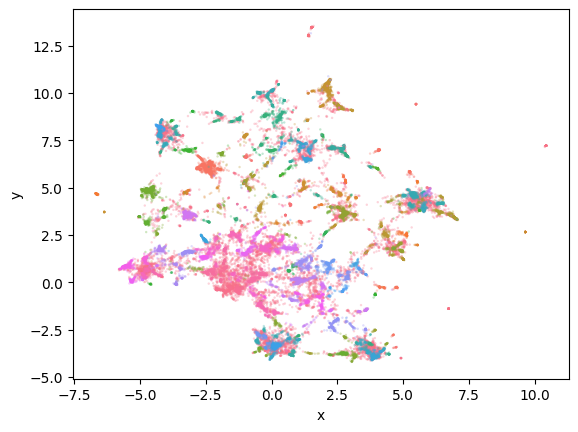

In [22]:
import seaborn as sns
import pandas as pd
import numpy as np

# Reduce 768-dimensional embeddings to 2 dimensions for easier visualization
reduced_embeddings_2 = UMAP(n_neighbors=15, n_components=2,
min_dist=0.0, metric='cosine').fit_transform(embeddings_arxiv)
df = pd.DataFrame(np.hstack([reduced_embeddings_2, clusters.reshape(-1, 1)]),
     columns=["x", "y", "cluster"]).sort_values("cluster")

# Visualize clusters
df.cluster = df.cluster.astype(int).astype(str)
sns.scatterplot(data=df, x='x', y='y', hue='cluster',
   linewidth=0, legend=False, s=3, alpha=0.3)

In [23]:
reduced_embeddings.shape, clusters.shape, np.array(abstracts).shape

((33189, 10), (33189,), (33189,))

In [24]:
df = pd.DataFrame(np.hstack([clusters.reshape(-1, 1), np.array(abstracts).reshape(-1,1)]),
                  columns=["cluster", "abstract"]).sort_values("cluster")


In [25]:
df.head(10)

,cluster,abstract
9406,-1,We study how language on social media is lin...
27013,-1,Sentence scoring aims at measuring the likel...
27011,-1,Theorem proving in natural mathematical lang...
21542,-1,Today's conflicts are becoming increasingly ...
27010,-1,Some questions have multiple answers that ar...
27008,-1,Language sciences rely less and less on form...
27005,-1,We show that large pre-trained language mode...
15501,-1,Evaluation of intelligent assistants in larg...
27004,-1,Recent works suggest that transformer models...
21532,-1,Supplementary Training on Intermediate Label...


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33189 entries, 9406 to 27342
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   cluster   33189 non-null  object
 1   abstract  33189 non-null  object
dtypes: object(2)
memory usage: 777.9+ KB


In [27]:
df.value_counts('cluster')

cluster
-1     10576
10      1021
41       661
87       546
232      429
       ...  
170       15
131       15
254       15
154       15
285       15
Length: 289, dtype: int64

In [28]:
unique_clusters = np.unique(clusters)
unique_clusters.shape

(289,)

In [29]:
unique_clusters

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 17

In [30]:
for index in np.where(clusters==59)[0][-10:]:
    print(abstracts[index])

  Modern embedding-based metrics for evaluation of generated text generally
fall into one of two paradigms: discriminative metrics that are trained to
directly predict which outputs are of higher quality according to supervised
human annotations, and generative metrics that are trained to evaluate text
based on the probabilities of a generative model. Both have their advantages;
discriminative metrics are able to directly optimize for the problem of
distinguishing between good and bad outputs, while generative metrics can be
trained using abundant raw text. In this paper, we present a framework that
combines the best of both worlds, using both supervised and unsupervised
signals from whatever data we have available. We operationalize this idea by
training T5Score, a metric that uses these training signals with mT5 as the
backbone. We perform an extensive empirical comparison with other existing
metrics on 5 datasets, 19 languages and 280 systems, demonstrating the utility
of our method

# Topic Modeling

Topic modeling is an analytical technique used to uncover latent themes or topics in extensive textual data. It identifies sets of keywords or phrases that encapsulate the essence of each topic, making it an invaluable tool for deciphering common themes across large text corpora. This approach transforms vast, unstructured text collections into meaningful clusters of similar content.

One of the classical and widely adopted methods in topic modeling is **Latent Dirichlet Allocation (LDA)**, introduced by Blei et al. in 2003. LDA operates on the premise that each document within a corpus is a mixture of various topics, with each topic defined by a specific probability distribution over the corpus’s vocabulary. For instance, a document focusing on advanced AI techniques might frequently include terms like “neural networks”, “deep learning”, and “algorithm optimization”, suggesting its alignment with certain topics.

While traditional topic modeling methods like LDA remain foundational in the field, the advent of Large Language Models (LLMs) has opened new avenues in topic analysis. Models like **BERTopic** represent an evolution in this domain, integrating the advanced capabilities of LLMs. BERTopic stands out for its flexible and modular architecture, allowing for the easy integration of newly developed language models. This adaptability ensures that as LLMs continue to advance, BERTopic evolves alongside, offering novel and potent ways to apply these models in topic modeling.

These developments signify a shift in topic modeling techniques, moving from traditional probabilistic methods to more dynamic and contextually aware approaches afforded by LLMs. Models like BERTopic leverage the depth of understanding in language provided by LLMs, resulting in more nuanced and accurately represented topics. This synergy between traditional topic modeling frameworks and modern LLMs exemplifies the ongoing innovation in the field, ensuring its relevance and applicability in a rapidly evolving digital landscape.

## BERTopic

<img src="https://drive.google.com/uc?export=view&id=130GEogTzjQRQ8wckX2ljFKapjhEJKMOa" width="600"/>

BERTopic, a flexible and advanced topic modeling technique, is structured into two main sections: **Clustering** and **Topic Representation**. Each section utilizes customizable steps, allowing for the use of various methods according to specific needs.

### Clustering
1. **Embedding Documents**: While BERTopic defaults to sentence-transformers models like "all-MiniLM-L6-v2", it allows for the use of any embedding model that captures semantic similarities in documents.
2. **Dimensionality Reduction**: UMAP is the default choice for reducing the high-dimensional embeddings, but alternative methods like PCA can be employed to maintain the essential structure for clustering.
3. **Clustering Documents**: HDBSCAN is used by default due to its effectiveness in identifying diverse cluster shapes and densities, but BERTopic can integrate other clustering techniques as needed.

### Topic Representation
1. **Bag-of-Words Approach**: After clustering, BERTopic combines all documents in a cluster into a single document and uses a bag-of-words model to count word frequencies. This approach is chosen because it makes minimal assumptions about the structure of the clusters, focusing instead on the frequency and distribution of words to represent topics.
2. **Class-Based TF-IDF**: This modified TF-IDF method, unique to BERTopic, emphasizes words that distinguish one cluster from others, highlighting representative terms for each topic.
3. **Fine-Tuning**: Although BERTopic initially relies on c-TF-IDF for topic representation, it can incorporate additional fine-tuning techniques, like GPT or T5, to refine the topics further.

BERTopic's strength lies in its modularity, allowing users to adapt each step, from embedding to topic representation, to suit diverse datasets and objectives, ensuring both accuracy and relevance in the topics it generates.

<img src="https://drive.google.com/uc?export=view&id=1I8v7bydn2PQ4oB5he8Bl3Lh_uBQR5M_j" width="800"/>

Image Source: https://maartengr.github.io/BERTopic/algorithm/algorithm.html#6-optional-fine-tune-topic-representation

**NOTE**: In the clustering process of BERTopic, each document is typically associated with just one cluster or topic. However, it's common for documents to encompass several topics. Strictly assigning such multi-topic documents to a single topic may not accurately reflect their content. While BERTopic addresses this issue through certain strategies, which will be discussed later, it's crucial to recognize that at its fundamental level, topic modeling in BERTopic essentially revolves around clustering tasks.

The code for the steps will look something like this:
```

from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer

from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer


# Step 1 - Extract embeddings (blue block)
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Step 2 - Reduce dimensionality (red block)
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')

# Step 3 - Cluster reduced embeddings (green block)
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# Step 4 - Tokenize topics (yellow block)
vectorizer_model = CountVectorizer(stop_words="english")

# Step 5 - Create topic representation (green block)
ctfidf_model = ClassTfidfTransformer()

# Step 6 - (Optional) Fine-tune topic representations with a `bertopic.representation` model (dark blue block)
representation_model = KeyBERTInspired()

# All steps together
topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
  representation_model=representation_model # Step 6 - (Optional) Fine-tune topic represenations
)

```

Source for code above: https://maartengr.github.io/BERTopic/algorithm/algorithm.html#6-optional-fine-tune-topic-representation

### Default Pipeline

In [31]:
# Default pipeline can be implemented in three lines of code

from bertopic import BERTopic
topic_model = BERTopic()
# topics, probs = topic_model.fit_transform(abstracts)

The key issues with using the default BERTopic model include:

- **Computational Efficiency**: Recalculating embeddings for each run is resource-heavy.
- **Stochastic Outcomes**: Default UMAP settings can lead to inconsistent results in dimensionality reduction.
- **Uncontrolled Topic Number**: The number of topics generated by default may not align with specific analytical needs.
- **Basic Topic Representations**: The default c-TF-IDF method might not fully capture the nuances in topic representation

Improving the default BERTopic model involves several key strategies:

1. **Pre-Calculating Embeddings**: Instead of recalculating embeddings for each iteration, which is resource-intensive, pre-calculate and store them. This approach speeds up the process as BERTopic can directly use these pre-computed embeddings.

2. **Controlling Stochastic Behavior in UMAP**: UMAP, used for dimensionality reduction, can yield different results on each run due to its stochastic nature. To achieve consistent results, set a fixed `random_state` in the UMAP model before integrating it with BERTopic.

3. **Managing the Number of Topics**: Rather than relying solely on BERTopic's `nr_topics` parameter, which merges existing topics, adjust the `min_topic_size` parameter in HDBSCAN. This indirectly influences the number of generated topics - a higher `min_topic_size` results in fewer topics, and vice versa.

4. **Enhancing Topic Representations**: The default c-TF-IDF method can be optimized using the `CountVectorizer`. By removing stopwords, ignoring infrequent words, and adjusting the n-gram range, you can refine the topic representations. This preprocessing step occurs after documents are assigned to topics and doesn't affect the clustering process.

These improvements collectively enhance BERTopic's efficiency, reproducibility, and the relevance of its topic representations.

### Improved Pipeline

In [32]:
# Improvement1 : we already have saved  embeddings, so we can use them to speed up the process

# improvement 2: add random_state to make the results reproducible
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

# improvement 3: add min_cluster_size to remove small topics
# we earlier used 15, let us try 40
hdbscan_model = HDBSCAN(min_cluster_size=40, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# improvement 4: Enhance topic representation by removing stopwords, infrequent words, and using bigrams
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_model = CountVectorizer(stop_words="english", min_df=2, ngram_range=(1, 2))



In [33]:
# Creating the BERTopic model with embedding model

# topic_model = BERTopic(embedding_model=embedding_model, umap_model=umap_model, hdbscan_model=hdbscan_model, vectorizer_model=vectorizer_model)
# topics, probs = topic_model.fit_transform(documents=abstracts)

# Creating the BERTopic model without embedding model
topic_model = BERTopic(embedding_model=embedding_model, umap_model=umap_model,
                       hdbscan_model=hdbscan_model, vectorizer_model=vectorizer_model,
                       calculate_probabilities=True)
topics, probs = topic_model.fit_transform(embeddings=embeddings_arxiv, documents=abstracts)


Using this pipeline, you'll receive three outputs: `topic_model`, `topics`, and `probs`:

- `topic_model` refers to the trained model, encompassing details about its configuration and the generated topics.
  - See attributes of `topic_moidel` available here: https://maartengr.github.io/BERTopic/api/bertopic.html
- `topics` indicates the specific topics assigned to each abstract.
- `probs` represents the likelihood of each topic being associated with a particular abstract.

### Interpreting Topics

#### Overall Summary of Topics

In [34]:
topic_model.get_topic_info().head(20)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,8670,-1_language_models_model_translation,"[language, models, model, translation, tasks, ...",[ Linguistic resources such as part-of-speech...
1,0,2320,0_dialogue_dialog_response_responses,"[dialogue, dialog, response, responses, intent...",[ Traditional goal-oriented dialogue systems ...
2,1,1703,1_speech_asr_speech recognition_recognition,"[speech, asr, speech recognition, recognition,...",[ Speech translation (ST) is the task of dire...
3,2,805,2_summarization_summaries_summary_abstractive,"[summarization, summaries, summary, abstractiv...",[ Automatic text summarization aims to produc...
4,3,649,3_hate_hate speech_offensive_speech,"[hate, hate speech, offensive, speech, detecti...",[ Hate speech is a challenging issue plaguing...
5,4,624,4_clinical_medical_biomedical_notes,"[clinical, medical, biomedical, notes, patient...",[ Coding diagnosis and procedures in medical ...
6,5,589,5_ner_named_entity_named entity,"[ner, named, entity, named entity, entity reco...",[ The task of named entity recognition (NER) ...
7,6,542,6_relation_relation extraction_extraction_rela...,"[relation, relation extraction, extraction, re...",[ Relation extraction is the task of identify...
8,7,508,7_question_qa_answer_answering,"[question, qa, answer, answering, question ans...",[ Information seeking is an essential step fo...
9,8,439,8_parsing_dependency_parser_parsers,"[parsing, dependency, parser, parsers, depende...",[ Dependency grammar induction is the task of...


The `topic_model.get_topic_info()` method provides an overview of the topics generated by the BERTopic model, including:

- **Topic IDs**: Each topic is assigned a unique identifier (e.g., 0, 1, 2, ...). The topic labeled "-1" typically represents outliers or noise.
- **Count**: The number of documents or abstracts assigned to each topic.
- **Name**: A descriptive name for each topic, derived from the most representative words or phrases in that topic (e.g., "0_dialogue_dialog_response_responses").
- **Representation**: Key words or phrases associated with each topic, which are indicative of the topic's content.
- **Representative Docs**: Excerpts or summaries from documents that are representative of each topic.
- **Outlier Topic (-1)**: The first topic, labeled as "-1", comprises documents not fitting within any defined topic, essentially considered outliers. This outcome is due to HDBSCAN's approach of not mandating every point to be part of a cluster. To address these outliers, one could either switch to a clustering algorithm like k-Means, which doesn't produce outliers, or utilize BERTopic’s reduce_outliers() function to reassign some outlier documents to existing topics.

This information is useful for understanding the distribution and thematic focus of the topics within your dataset. For example, topic 0 seems to focus on dialogues and responses, while topic 2 is about speech recognition. The "Count" column shows the prevalence of each topic in your dataset.

#### Get individual Topic Info

The get_topic() function can be used to extract and highlight these top 10 keywords and their respective importance within the topic, providing a clear thematic overview.

In [35]:
topic_model.get_topic(0)

[('dialogue', 0.022352047337285026),
 ('dialog', 0.012880034653299172),
 ('response', 0.009644972412037506),
 ('responses', 0.00901344664784425),
 ('intent', 0.008094272204096514),
 ('oriented', 0.007538025370593823),
 ('user', 0.007532026496960061),
 ('conversation', 0.0074655979167858105),
 ('conversational', 0.007457761953337973),
 ('systems', 0.007416613241973514)]

In the provided example, Topic 0 is characterized by keywords such as 'dialogue', 'dialog', 'response', 'responses', and 'intent', with corresponding c-TF-IDF weights indicating their significance within the topic. These keywords collectively suggest that the central theme of Topic 0 is likely related to dialogues and conversational interactions, possibly in the context of conversational AI or dialogue systems.

#### Find Topics related to a keyword

In [36]:
# DO NOT RUN THIS CELL
# This method can only be used if you did not use custom embeddings.
# topic_model.find_topics("summarization")

In [37]:
# DO NOT RUN THIS CELL
# topic_model.get_topic(57)

In [38]:
# topic_model.find_topics??

In [39]:
import numpy as np
embedding_model = SentenceTransformer('all-mpnet-base-v2')
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def find_similar_topics(embedding_model, topic_model, search_term, top_n=5):
    # Get sorted list of topic IDs from BERTopic model
    topic_list = list(topic_model.topic_representations_.keys())
    topic_list.sort()

    # Generate search term embedding
    search_term_embedding = embedding_model.encode([search_term]).flatten()

    # Compute cosine similarity
    similarities = cosine_similarity(search_term_embedding.reshape(1, -1), topic_model.topic_embeddings_).flatten()

    # Find top n similar topics
    top_indices = np.argsort(similarities)[-top_n:][::-1]
    similar_topics = [topic_list[i] for i in top_indices]
    similarity_scores = [similarities[i] for i in top_indices]


    return similar_topics, similarity_scores


In [40]:
# Usage
similar_topics, similarity_scores = find_similar_topics(embedding_model, topic_model, "summarization", top_n=5)

In [41]:
similar_topics, similarity_scores

([2, 137, 78, 72, 129],
 [0.61095357, 0.55867803, 0.5062338, 0.4585247, 0.4493335])

In [42]:
topic_model.get_topic(3)

[('hate', 0.034494513375629365),
 ('hate speech', 0.029087401208809763),
 ('offensive', 0.02284206017154196),
 ('speech', 0.015019615065756355),
 ('detection', 0.014420455599589958),
 ('social', 0.012915960240323049),
 ('toxic', 0.012290161754023771),
 ('offensive language', 0.011610364744947841),
 ('content', 0.01135719729461135),
 ('social media', 0.011231817424934615)]

In [43]:
topic_model.get_topic(76)

[('tuning', 0.034994643150399546),
 ('fine tuning', 0.025494021818561686),
 ('fine', 0.022139452255586608),
 ('parameters', 0.016915580495869355),
 ('parameter', 0.015981262782417446),
 ('parameter efficient', 0.014386695724455178),
 ('tasks', 0.014107978145259856),
 ('task', 0.011623348715886474),
 ('efficient', 0.011504231741492461),
 ('plms', 0.011229369482034414)]

In [44]:
topic_model.get_topic(71)

[('reasoning', 0.05830538119641272),
 ('cot', 0.02360638012001717),
 ('prompting', 0.021615916016944407),
 ('logical', 0.019283358362202196),
 ('llms', 0.018821580569730715),
 ('chain thought', 0.015419403438019697),
 ('chain', 0.014839930010950991),
 ('thought', 0.013717207005270272),
 ('logical reasoning', 0.01321006664306937),
 ('proof', 0.011831255886991333)]

In [45]:
topic_model.get_topic(128)

[('active learning', 0.07712416591455362),
 ('active', 0.07478321824744247),
 ('al', 0.0328280267360711),
 ('learning', 0.024043723421360116),
 ('uncertainty', 0.021454017244806254),
 ('learning al', 0.01638681898729882),
 ('sampling', 0.01581939967851964),
 ('labeling', 0.01193343624069586),
 ('uncertainty based', 0.011865049620811611),
 ('annotation', 0.01170540416304618)]

In [46]:
topic_model.get_topic(57)

[('medical', 0.034075252087520706),
 ('question', 0.014654094093722396),
 ('patient', 0.013539279992011223),
 ('questions', 0.012956757041595391),
 ('qa', 0.01239886383881704),
 ('clinical', 0.012127674330755766),
 ('medical dialogue', 0.010786139412440108),
 ('bioasq', 0.01064196820251322),
 ('answering', 0.009313216548757467),
 ('doctor', 0.00914723992015614)]

#### Topics for Documents

In [47]:
topic_model.get_document_info(abstracts)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,In this paper Arabic was investigated from t...,1,1_speech_asr_speech recognition_recognition,"[speech, asr, speech recognition, recognition,...",[ Speech translation (ST) is the task of dire...,speech - asr - speech recognition - recognitio...,0.076031,False
1,In this paper we present the creation of an ...,1,1_speech_asr_speech recognition_recognition,"[speech, asr, speech recognition, recognition,...",[ Speech translation (ST) is the task of dire...,speech - asr - speech recognition - recognitio...,0.087556,False
2,Intelligent Input Methods (IM) are essential...,-1,-1_language_models_model_translation,"[language, models, model, translation, tasks, ...",[ Linguistic resources such as part-of-speech...,language - models - model - translation - task...,0.345668,False
3,This paper includes a reflection on the role...,125,125_word order_dependency_order_syntactic,"[word order, dependency, order, syntactic, min...",[ The syntactic structure of a sentence is of...,word order - dependency - order - syntactic - ...,0.100732,False
4,"We test a segmentation algorithm, based on t...",-1,-1_language_models_model_translation,"[language, models, model, translation, tasks, ...",[ Linguistic resources such as part-of-speech...,language - models - model - translation - task...,0.488053,False
...,...,...,...,...,...,...,...,...
33184,Verbs are sometimes omitted in Japanese sent...,-1,-1_language_models_model_translation,"[language, models, model, translation, tasks, ...",[ Linguistic resources such as part-of-speech...,language - models - model - translation - task...,0.911950,False
33185,We have developed a new method for Japanese-...,106,106_translation_machine translation_machine_st...,"[translation, machine translation, machine, st...",[ This paper discusses Centre for Development...,translation - machine translation - machine - ...,0.213316,False
33186,A system is described that uses a mixed-leve...,-1,-1_language_models_model_translation,"[language, models, model, translation, tasks, ...",[ Linguistic resources such as part-of-speech...,language - models - model - translation - task...,0.746196,False
33187,We present a technique which complements Hid...,-1,-1_language_models_model_translation,"[language, models, model, translation, tasks, ...",[ Linguistic resources such as part-of-speech...,language - models - model - translation - task...,0.350917,False


In [48]:
print_wrap(abstracts[0])

  In this paper Arabic was investigated from the speech recognition problem
point of view. We propose a novel approach to build an Arabic Automated Speech
Recognition System (ASR). This system is based on the open source CMU Sphinx-4,
from the Carnegie Mellon University. CMU Sphinx is a large-vocabulary; speaker-
independent, continuous speech recognition system based on discrete Hidden
Markov Models (HMMs). We build a model using utilities from the OpenSource CMU
Sphinx. We will demonstrate the possible adaptability of this system to Arabic
voice recognition.


In [49]:
topics[0], probs[0]

(1,
 array([0.00481162, 0.07603095, 0.00365653, 0.00430695, 0.00365774,
        0.00589393, 0.00421358, 0.00460922, 0.00781157, 0.00486352,
        0.00678607, 0.01103272, 0.00433514, 0.00521552, 0.00492774,
        0.00721288, 0.00451966, 0.00605637, 0.00848121, 0.00555011,
        0.00771006, 0.00508794, 0.00612767, 0.00690426, 0.00453454,
        0.00672535, 0.00513369, 0.00620939, 0.0067082 , 0.00391279,
        0.00649289, 0.01174769, 0.00410379, 0.01861905, 0.00848965,
        0.004904  , 0.00457752, 0.00734282, 0.01071299, 0.00444707,
        0.00897398, 0.00464496, 0.00439218, 0.01226167, 0.00882314,
        0.00435481, 0.00466822, 0.0038852 , 0.0061865 , 0.00647137,
        0.00514067, 0.00457315, 0.00842538, 0.00581483, 0.00556064,
        0.00377767, 0.0047485 , 0.00364071, 0.00548211, 0.0080783 ,
        0.00508385, 0.00422786, 0.00494197, 0.01595516, 0.00638546,
        0.00694708, 0.00478127, 0.00453693, 0.0079049 , 0.0052375 ,
        0.00817379, 0.00569661, 0.00698264, 

In [50]:
top_five_topics_for_doc1 = np.argsort(probs[0])[-5:][::-1]
top_five_probs_doc1 = probs[0][top_five_topics_for_doc1]
top_five_topics_for_doc1, top_five_probs_doc1

(array([  1, 114,  33, 127,  63]),
 array([0.07603095, 0.04667693, 0.01861905, 0.01683579, 0.01595516]))

In [51]:
topic_model.get_topic(1)

[('speech', 0.02827289153702467),
 ('asr', 0.016727701574842532),
 ('speech recognition', 0.015206059463843201),
 ('recognition', 0.014339481502930426),
 ('end', 0.010433463203495388),
 ('acoustic', 0.010286332743202127),
 ('automatic speech', 0.008051844310552688),
 ('speaker', 0.007591219653708118),
 ('end end', 0.007186199493435112),
 ('audio', 0.006726001196370792)]

In [52]:
topic_model.get_topic(36)

[('knowledge graph', 0.029161463757486843),
 ('knowledge', 0.027000381281482157),
 ('graph', 0.02654500778622926),
 ('link prediction', 0.021049294578363124),
 ('link', 0.01877987103113936),
 ('entities', 0.018514199100034004),
 ('kg', 0.018329646489619635),
 ('knowledge graphs', 0.017849657666300575),
 ('embedding', 0.016926800738236186),
 ('completion', 0.016914131699937246)]

In [53]:
topic_model.get_topic(121)

[('phylogenetic', 0.04811652282641777),
 ('cognate', 0.0464060691788595),
 ('cognates', 0.03407723286082759),
 ('languages', 0.022219924064192036),
 ('indo', 0.018394599477268982),
 ('historical', 0.018215873034961628),
 ('family', 0.017899309781530048),
 ('cognate detection', 0.015645401656515203),
 ('indo european', 0.01554872835410308),
 ('dialects', 0.014106694685603733)]

In [54]:
topic_model.visualize_distribution(probs[0])

#### Approximate Topic Distribution

For more details, refer to https://maartengr.github.io/BERTopic/getting_started/distribution/distribution.html


In [55]:
topic_distr, _ = topic_model.approximate_distribution(abstracts)

In [56]:
topic_model.visualize_distribution(topic_distr[0])

In [57]:
# this can take a long time to run
# topic_distr, _ = topic_model.approximate_distribution(abstracts, use_embedding_model=True)

In [58]:
# Calculate the topic distributions on a token-level
topic_distr, topic_token_distr = topic_model.approximate_distribution(abstracts, calculate_tokens=True)

# Visualize the token-level distributions
df = topic_model.visualize_approximate_distribution(abstracts[0], topic_token_distr[0])
df


,In,this,paper,Arabic,was,investigated,from,the,speech,recognition,problem,point,of,view,We,propose,novel,approach,to,build,an,Arabic,Automated,Speech,Recognition,System,ASR,This,system,is,based,on,the,open,source,CMU,Sphinx,from,the,Carnegie,Mellon,University,CMU,Sphinx,is,large,vocabulary,speaker,independent,continuous,speech,recognition,system,based,on,discrete,Hidden,Markov,Models,HMMs,We,build,model,using,utilities,from,the,OpenSource,CMU,Sphinx,We,will,demonstrate,the,possible,adaptability,of,this,system,to,Arabic,voice,recognition
1_speech_asr_speech recognition_recognition,0.000,0.000,0.000,0.000,0.000,0.000,0.425,0.617,0.749,0.749,0.324,0.131,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.187,0.382,0.811,1.081,1.127,1.165,0.736,0.466,0.233,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.109,0.314,0.528,0.737,0.628,0.423,0.209,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
5_ner_named_entity_named entity,0.000,0.000,0.000,0.000,0.000,0.000,0.103,0.103,0.103,0.103,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
33_code_switching_identification_code mixed,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.111,0.111,0.111,0.111,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.141,0.141,0.141,0.141,0.000,0.000
46_sentiment_sentiment analysis_analysis_polarity,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.120,0.120,0.120,0.120,0.000,0.000
98_ocr_diacritization_character_diacritics,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.112,0.112,0.112,0.112,0.000,0.000
103_arabic_morphological_arabizi_arabic language,0.221,0.442,0.648,1.056,0.835,0.614,0.408,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.498,0.896,1.147,1.380,0.882,0.483,0.233,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.667,1.069,1.280,1.280,0.613,0.211
111_scoring_essay_aes_grading,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.102,0.102,0.102,0.102,0.000,0.000,0.000,0.000,0.000,0.000,0.

#### Interactive Visualizations

In [59]:
topic_model.visualize_topics()

In [60]:
topic_model.visualize_barchart(top_n_topics=20)

In [61]:
topic_model.visualize_barchart(topics=list(range(50, 58, 1)))

### Hierarchical Topics
In BERTopic for creating a hierarchical structure of topics, the default choice is Scipy's ward linkage function. Nonetheless, depending on your specific requirements, you might prefer other linkage functions like single, complete, average, centroid, or median. BERTopic offers the flexibility to customize the linkage function and even select the desired distance function to suit your particular use case.


In [62]:
from scipy.cluster import hierarchy as sch

# Hierarchical topics
# linkage_function = lambda x: sch.linkage(x, 'single', optimal_ordering=True)
# hierarchical_topics = topic_model.hierarchical_topics(docs, linkage_function=linkage_function)

hierarchical_topics = topic_model.hierarchical_topics(abstracts)
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)


100%|██████████| 139/139 [00:02<00:00, 67.67it/s]


### Representation Models

BERTopic's design enables it to utilize a variety of Large Language Models (LLMs) efficiently for refining topic representations. With BERTopic, one can employ diverse fine-tuning methods, ranging from part-of-speech tagging to advanced text-generation techniques like those used in models similar to ChatGPT. The broad spectrum of LLMs compatible with BERTopic for fine-tuning is exemplified in the figure below:

<img src="https://drive.google.com/uc?export=view&id=1K7f6jDeevS1h9_VCfI8MoZqSdvfgxKa-" width="800"/>

The initial rankings of words within topics, created using c-TF-IDF in BERTopic, act as preliminary or candidate keywords for each topic. These rankings might be adjusted based on different representation models. In the following sections, we will explore various representation models to refine and enhance the initial topic word rankings provided by c-TF-IDF.


In [63]:
topic_model.topic_representations_

{-1: [('language', 0.0055675928000213),
  ('models', 0.005211111861989376),
  ('model', 0.004752128425245839),
  ('translation', 0.004518903134657779),
  ('tasks', 0.0044067652619312605),
  ('data', 0.004330891888799993),
  ('text', 0.0040794648791247935),
  ('based', 0.004015223093091549),
  ('task', 0.003859311543751523),
  ('training', 0.003804018355988631)],
 0: [('dialogue', 0.022352047337285026),
  ('dialog', 0.012880034653299172),
  ('response', 0.009644972412037506),
  ('responses', 0.00901344664784425),
  ('intent', 0.008094272204096514),
  ('oriented', 0.007538025370593823),
  ('user', 0.007532026496960061),
  ('conversation', 0.0074655979167858105),
  ('conversational', 0.007457761953337973),
  ('systems', 0.007416613241973514)],
 1: [('speech', 0.02827289153702467),
  ('asr', 0.016727701574842532),
  ('speech recognition', 0.015206059463843201),
  ('recognition', 0.014339481502930426),
  ('end', 0.010433463203495388),
  ('acoustic', 0.010286332743202127),
  ('automatic spee

In [64]:
# Save original representations
from copy import deepcopy
original_topics = deepcopy(topic_model.topic_representations_)

In [65]:
def compare_topic_changes(new_model, original_topic_words, max_length=75, top_n_topics=10):

    """Displays differences in top words of topic representations between the original and new models."""

    for topic_id in range(top_n_topics):
        # Extract top 5 words per topic from the original and new models
        original_top_words = "_".join(word for word, _ in original_topic_words[topic_id][:5])
        new_top_words = "_".join(word for word, _ in new_model.get_topic(topic_id)[:5])

        # Calculate whitespace for alignment
        alignment_spaces = " " * (max_length - len(original_top_words))

        # Print 'before' and 'after' topic word changes
        print(f"Topic: {topic_id}    {original_top_words}{alignment_spaces} >>     {new_top_words}")


#### KeyBERTInspired

The KeyBERTInspired model in BERTopic enhances topic representations by combining c-TF-IDF with semantic relationships. It starts by selecting representative documents for each topic by typically sampling 500 and calculating their c-TF-IDF values. These documents are then embedded and averaged to create an updated topic embedding. This process allows for the re-ranking of candidate keywords based on their similarity to the updated topic embedding. Unlike centroid-based methods, this approach accounts for the structure of each topic's cluster, leveraging the semantic relationships between keywords/keyphrases and the documents within a topic for more precise fine-tuning of topic representations.

<img src="https://drive.google.com/uc?export=view&id=1g3gmYg9M_MBicj5OY0W4c7hGMvmFvYA3" width="600"/>


In [66]:
# KeyBERTInspired
from bertopic.representation import KeyBERTInspired
representation_model = KeyBERTInspired()

# Update our topic representations
topic_model.update_topics(abstracts, representation_model=representation_model)


In [67]:
# Show topic differences
compare_topic_changes(topic_model, original_topics)

Topic: 0    dialogue_dialog_response_responses_intent                                   >>     dialog_dialogues_dialogue_conversational_conversation
Topic: 1    speech_asr_speech recognition_recognition_end                               >>     rnn_transcription_decoder_voice_asr
Topic: 2    summarization_summaries_summary_abstractive_document                        >>     summarization_summaries_summary_text_sentences
Topic: 3    hate_hate speech_offensive_speech_detection                                 >>     hate_hateful_cyberbullying_language_classifiers
Topic: 4    clinical_medical_biomedical_notes_patient                                   >>     embeddings_nlp_ehrs_ehr_annotated
Topic: 5    ner_named_entity_named entity_entity recognition                            >>     nlp_entity_entities_annotation_annotated
Topic: 6    relation_relation extraction_extraction_relations_entity                    >>     relation_relations_extracting_relational_sentence
Topic: 7    question_qa_a

In [68]:
topic_model.get_topic(2, full=True)

{'Main': [('summarization', 0.61764216),
  ('summaries', 0.46429121),
  ('summary', 0.42946965),
  ('text', 0.3094666),
  ('sentences', 0.2996396),
  ('extractive', 0.27653193),
  ('sentence', 0.23959783),
  ('articles', 0.23445834),
  ('content', 0.21842799),
  ('attention', 0.20796657)]}

In [69]:
# topic_model.topic_representations_

In [70]:
hierarchical_topics = topic_model.hierarchical_topics(abstracts)
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

100%|██████████| 139/139 [00:33<00:00,  4.13it/s]


#### OpenAI

In [78]:
# OpenAI Representation Model
prompt = """
I have a topic that contains the following documents: \n[DOCUMENTS]
The topic is described by the following keywords: [KEYWORDS]

Based on the information above, extract a short topic label in the following format:
topic: <topic label>
"""



In [88]:
from google.colab import userdata
openai_key = userdata.get('clustering')


In [89]:
import openai
import tiktoken
from bertopic.representation import OpenAI
from bertopic import BERTopic

# Tokenizer
tokenizer= tiktoken.encoding_for_model("gpt-3.5-turbo")

# Create your representation model
client = openai.OpenAI(api_key=openai_key)
representation_model = OpenAI(
    client,
    model="gpt-3.5-turbo",
    delay_in_seconds=2,
    chat=True,
    nr_docs=4,
    doc_length=100,
    tokenizer=tokenizer
)
representation_model = OpenAI(client, model="gpt-3.5-turbo", delay_in_seconds=10, chat=True)


In [90]:
# Update our topic representations
topic_model.update_topics(abstracts, representation_model=representation_model)

Useful Links:
Faster Topic Modeling with BERTopic and RAPIDS cuML: https://medium.com/rapids-ai/faster-topic-modeling-with-bertopic-and-rapids-cuml-5c7559aba898


In [92]:
topic_model.representation_model.prompts_[0]

'\nI have a topic that contains the following documents: \n-   Natural language processing is a prompt research area across the country.\nParsing is one of the very crucial tool in language analysis system which aims\nto forecast the structural relationship among the words in a given sentence.\nMany researchers have already developed so many language tools but the accuracy\nis not meet out the human expectation level, thus the research is still exists.\nMachine translation is one of the major application area under Natural Language\nProcessing. While translation between one language to another language, the\nstructure identification of a sentence play a key role. This paper introduces\nthe hybrid way to solve the identification of relationship among the given\nwords in a sentence. In existing system is implemented using rule based\napproach, which is not suited in huge amount of data. The machine learning\napproaches is suitable for handle larger amount of data and also to get better\n

In [93]:
# Show topic differences
compare_topic_changes(topic_model, original_topics)

Topic: 0    dialogue_dialog_response_responses_intent                                   >>     Dialog Systems for Goal-Oriented Conversations
Topic: 1    speech_asr_speech recognition_recognition_end                               >>     End-to-End Speech Recognition and ASR Training
Topic: 2    summarization_summaries_summary_abstractive_document                        >>     Document Summarization Models and Approaches
Topic: 3    hate_hate speech_offensive_speech_detection                                 >>     Hate Speech Detection in Multilingual Social Media
Topic: 4    clinical_medical_biomedical_notes_patient                                   >>     Clinical concept extraction and utilization in healthcare data
Topic: 5    ner_named_entity_named entity_entity recognition                            >>     Named Entity Recognition (NER) Models for Flat and Nested Entities
Topic: 6    relation_relation extraction_extraction_relations_entity                    >>     Joint Entity an

In [94]:
hierarchical_topics = topic_model.hierarchical_topics(abstracts)
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

100%|██████████| 139/139 [35:48<00:00, 15.45s/it]
